In [1]:
import torch.nn as nn 
import torch 
import torchvision 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from tqdm import tqdm 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
import os 
import yaml 
import wandb  

from src import Convolution_Auto_Encoder, Mnist_Dataset,MVtecADDataset,Datadir_init
from src import MVtecEncoder,MVtecDecoder,Convolution_Auto_Encoder

cfg = {'seed':42,
       'img_size':256,
       'device':'cuda:0',
       'encoded_space_dim':256,
       'lr':0.001,
       'weight_decay':1e-05,
       'batch_size':32,
       'Epochs':50,
       'target_class':6,
       'save_dir':'MVtecAD3',
       'Dataset_dir':'./Dataset/hazelnut',
       'optimizer':'adamw',
       'Decription':'Normalize제외 하고 진행'}

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(cfg,augmentation=None):
    #mk save dir 
    try:
        os.mkdir(f"./Save_models/{cfg['save_dir']}")
    except:
        pass
    torch.manual_seed(cfg['seed'])
    data_dir = cfg['Dataset_dir']
    Data_dir = Datadir_init()
    train_dirs = Data_dir.train_load()
    test_dirs,test_labels = Data_dir.test_load()
    indx = int(len(train_dirs)*0.8)

    train_dset = MVtecADDataset(cfg,train_dirs[:indx],Augmentation=augmentation)
    valid_dset = MVtecADDataset(cfg,train_dirs[indx:],Augmentation=augmentation)
    test_dset = MVtecADDataset(cfg,test_dirs,test_labels,Augmentation=augmentation)

    train_loader = DataLoader(train_dset,batch_size=cfg['batch_size'],shuffle=True)
    valid_loader = DataLoader(valid_dset,batch_size=cfg['batch_size'],shuffle=False)
    test_loader = DataLoader(test_dset,batch_size=cfg['batch_size'],shuffle=False)
    return train_loader,valid_loader,test_loader 

def train_epoch(model,dataloader,criterion,optimizer,scheduler,scaler):
       model.train()
       optimizer.zero_grad()
       train_loss = [] 
       for img,label in dataloader:
              img = img.to(cfg['device']).type(torch.float32)
              with torch.cuda.amp.autocast():
                    y_pred = model(img).type(torch.float32)
                    loss = torch.sqrt(criterion(img,y_pred))
              #y_pred = model(img).type(torch.float32)
              

              #Backpropagation
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update() 
              #loss.backward()
              #optimizer.step()

              #loss save 
              train_loss.append(loss.detach().cpu().numpy())
       scheduler.step() 
       print(f'\t epoch : {epoch+1} train loss : {np.mean(train_loss):.3f}')
       return np.mean(train_loss)

def valid_epoch(model,dataloader,criterion):
       model.eval()
       valid_loss = [] 
       with torch.no_grad():
              for img,label in dataloader:
                     img = img.to(cfg['device'])
                     y_pred = model(img)
                     loss = torch.sqrt(criterion(y_pred,img))
                     valid_loss.append(loss.detach().cpu().numpy())
       print(f'\t epoch : {epoch+1} valid loss : {np.mean(valid_loss):.3f}')
       fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(5, 5))
       ax1.imshow(img[0].detach().cpu().permute(1,2,0).numpy())
       ax2.imshow(y_pred[0].detach().cpu().permute(1,2,0).numpy())
       plt.show()
       return np.mean(valid_loss)   

  0%|          | 0/50 [00:00<?, ?it/s]

	 epoch : 1 train loss : 0.318
	 epoch : 1 valid loss : 0.305


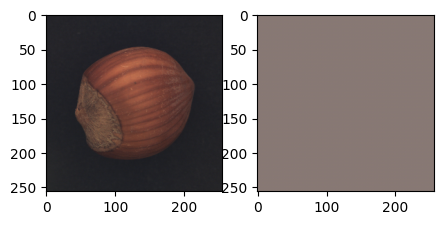

  2%|▏         | 1/50 [00:14<11:41, 14.31s/it]

	 Model save : 0 | best loss : 0.305
	 epoch : 2 train loss : 0.302
	 epoch : 2 valid loss : 0.293


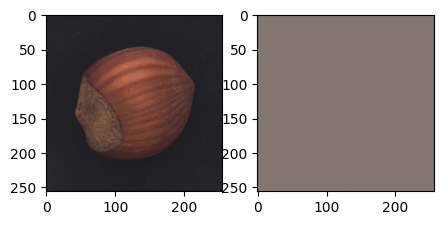

  4%|▍         | 2/50 [00:28<11:15, 14.07s/it]

	 Model save : 1 | best loss : 0.293
	 epoch : 3 train loss : 0.280
	 epoch : 3 valid loss : 0.269


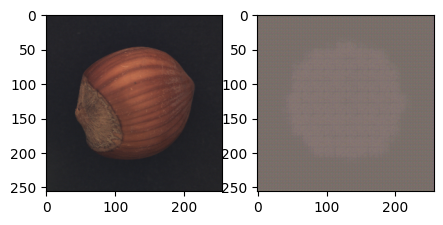

  6%|▌         | 3/50 [00:42<11:00, 14.05s/it]

	 Model save : 2 | best loss : 0.269
	 epoch : 4 train loss : 0.253
	 epoch : 4 valid loss : 0.236


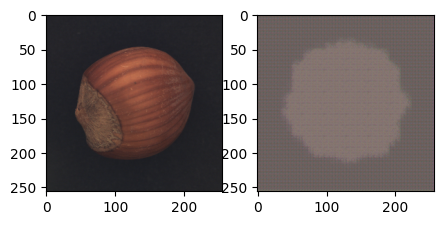

  8%|▊         | 4/50 [00:56<10:46, 14.04s/it]

	 Model save : 3 | best loss : 0.236
	 epoch : 5 train loss : 0.226
	 epoch : 5 valid loss : 0.205


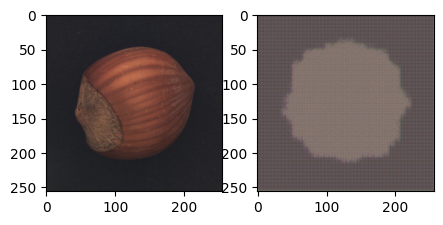

 10%|█         | 5/50 [01:10<10:32, 14.05s/it]

	 Model save : 4 | best loss : 0.205
	 epoch : 6 train loss : 0.201
	 epoch : 6 valid loss : 0.180


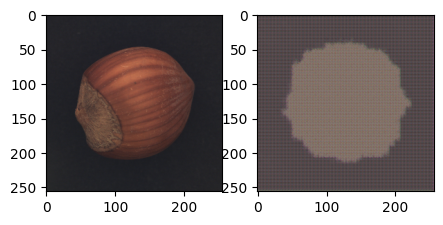

 12%|█▏        | 6/50 [01:24<10:21, 14.12s/it]

	 Model save : 5 | best loss : 0.180
	 epoch : 7 train loss : 0.179
	 epoch : 7 valid loss : 0.160


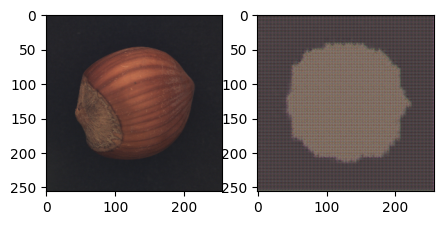

 14%|█▍        | 7/50 [01:38<10:06, 14.11s/it]

	 Model save : 6 | best loss : 0.160
	 epoch : 8 train loss : 0.160
	 epoch : 8 valid loss : 0.142


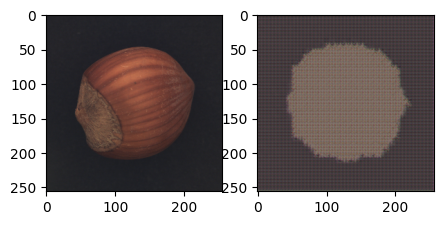

 16%|█▌        | 8/50 [01:52<09:52, 14.11s/it]

	 Model save : 7 | best loss : 0.142
	 epoch : 9 train loss : 0.142
	 epoch : 9 valid loss : 0.126


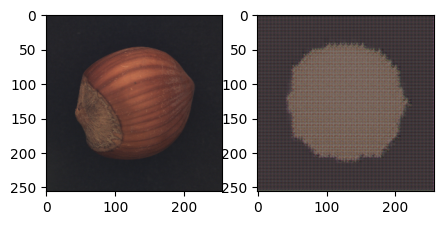

 18%|█▊        | 9/50 [02:06<09:38, 14.10s/it]

	 Model save : 8 | best loss : 0.126
	 epoch : 10 train loss : 0.127
	 epoch : 10 valid loss : 0.111


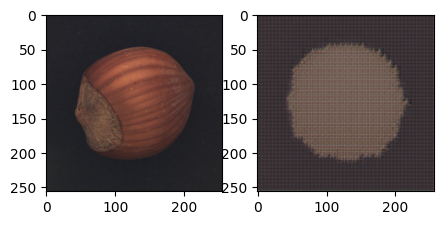

 20%|██        | 10/50 [02:20<09:21, 14.04s/it]

	 Model save : 9 | best loss : 0.111
	 epoch : 11 train loss : 0.114
	 epoch : 11 valid loss : 0.099


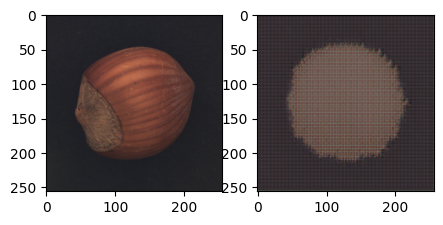

 22%|██▏       | 11/50 [02:34<09:08, 14.07s/it]

	 Model save : 10 | best loss : 0.099
	 epoch : 12 train loss : 0.104
	 epoch : 12 valid loss : 0.089


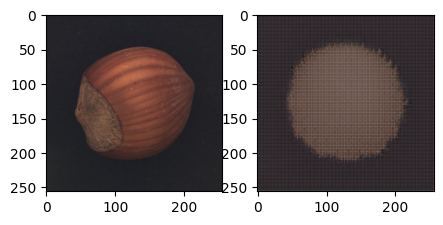

 24%|██▍       | 12/50 [02:48<08:54, 14.06s/it]

	 Model save : 11 | best loss : 0.089
	 epoch : 13 train loss : 0.095
	 epoch : 13 valid loss : 0.084


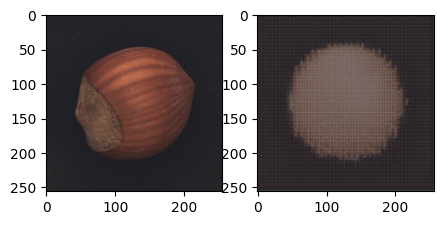

 26%|██▌       | 13/50 [03:03<08:40, 14.06s/it]

	 Model save : 12 | best loss : 0.084
	 epoch : 14 train loss : 0.086
	 epoch : 14 valid loss : 0.072


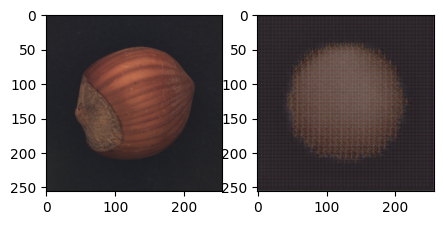

 28%|██▊       | 14/50 [03:17<08:26, 14.06s/it]

	 Model save : 13 | best loss : 0.072
	 epoch : 15 train loss : 0.079
	 epoch : 15 valid loss : 0.069


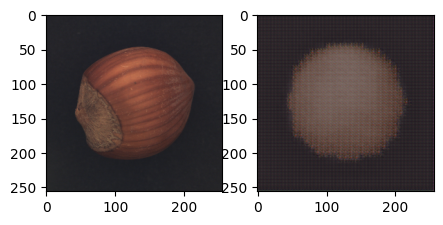

 30%|███       | 15/50 [03:31<08:12, 14.06s/it]

	 Model save : 14 | best loss : 0.069
	 epoch : 16 train loss : 0.074
	 epoch : 16 valid loss : 0.064


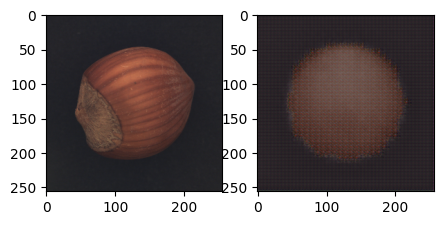

 32%|███▏      | 16/50 [03:45<07:58, 14.07s/it]

	 Model save : 15 | best loss : 0.064
	 epoch : 17 train loss : 0.069
	 epoch : 17 valid loss : 0.070


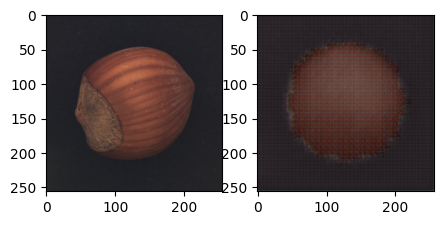

 34%|███▍      | 17/50 [03:59<07:43, 14.04s/it]

	 epoch : 18 train loss : 0.066
	 epoch : 18 valid loss : 0.079


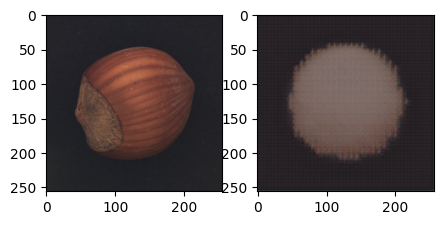

 36%|███▌      | 18/50 [04:13<07:29, 14.04s/it]

	 epoch : 19 train loss : 0.064
	 epoch : 19 valid loss : 0.062


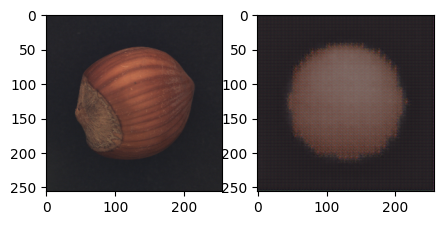

 38%|███▊      | 19/50 [04:27<07:15, 14.06s/it]

	 Model save : 18 | best loss : 0.062
	 epoch : 20 train loss : 0.062
	 epoch : 20 valid loss : 0.060


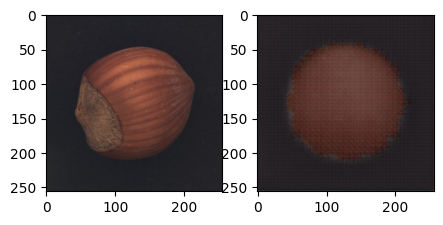

 40%|████      | 20/50 [04:41<07:01, 14.06s/it]

	 Model save : 19 | best loss : 0.060


In [3]:
#train_loader, valid_normal_loader,valid_anomal_loader  = preprocess(cfg)
train_loader,valid_loader,test_loader   = preprocess(cfg)
model = Convolution_Auto_Encoder(MVtecEncoder,MVtecDecoder,cfg['encoded_space_dim']).to(cfg['device'])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=cfg['lr'],weight_decay=cfg['weight_decay'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=100,eta_min=0)
scaler = torch.cuda.amp.GradScaler()


total_train_loss = [] 
total_valid_loss = [] 
best_valid_loss = np.inf 

for epoch in tqdm(range(cfg['Epochs'])):
    train_loss = train_epoch(model,train_loader,criterion,optimizer,scheduler,scaler)
    valid_loss = valid_epoch(model,valid_loader,criterion)
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model,f"./Save_models/{cfg['save_dir']}/best.pt")
        best_valid_loss = valid_loss 
        print(f'\t Model save : {epoch} | best loss : {best_valid_loss :.3f}')
        cfg['save_epoch'] = epoch 
        cfg['best_valid_loss'] = best_valid_loss
    
    if valid_loss != valid_loss:
        model = torch.load(f"./Save_models/{cfg['save_dir']}/best.pt")
        print('Model rewinded')
cfg['last_train_loss'] = total_train_loss[-1]
cfg['last_valid_loss'] = total_valid_loss[-1]

f = open(f"./Save_models/{cfg['save_dir']}/config.yaml",'w+')
yaml.dump(cfg, f, allow_unicode=True)
    
    